In [1]:
import os
import numpy as np
np.random.seed(123)
from six.moves import cPickle

import keras
import tensorflow as tf

from keras import backend as K
# from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

from prednet import PredNet
# from data_utils import SequenceGenerator
from kitti_settings import *

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
import time

Using TensorFlow backend.


In [2]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))
RAD_id_list = raw_RAD_id_list

5000


In [20]:
def check_RAD_id(RAD_id):
    mean_list = []
    for k in range(61):
        mean_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().mean())
    mean_list = np.array(mean_list)
    if i % 100 == 0:
        print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
        print(i, mean_list[:6])
    if mean_list.mean() < 1:
        return False
    for k in range(59):
        if abs(mean_list[k] + mean_list[k + 2] - 2 * mean_list[k + 1]) > 2:
            return False
    return True

In [21]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = []
for (i, RAD_id) in enumerate(raw_RAD_id_list):
    if check_RAD_id(RAD_id):
        RAD_id_list.append(RAD_id)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

start time: 2018-08-30 01:20:10
00:00:00
0 [-0.87143478 -0.88864586 -0.87570966 -0.87651842 -0.85615197 -0.85808025]
00:00:04
100 [0.93458592 0.94748228 0.91407206 0.97729093 0.9896096  0.95768941]
00:00:08
200 [0.63846758 0.81406847 0.84174963 1.11912702 1.17828216 1.40408206]
00:00:13
300 [-0.70275019 -0.60799758 -0.57519691 -0.53383054 -0.47055191 -0.42185489]
00:00:17
400 [3.6213282  3.81463022 3.72164653 3.65255517 3.61006928 3.63974646]
00:00:21
500 [-0.82312819 -0.84708427 -0.86941088 -0.86395672 -0.89204425 -0.87515588]
00:00:26
600 [-0.64371855 -0.6432564  -0.65860295 -0.65442369 -0.6496747  -0.67613276]
00:00:30
700 [7.77424791 0.75098904 0.68460683 0.60291393 0.59950757 0.56755551]
00:00:35
800 [-0.27642121 -0.20599918 -0.12073259 -0.05030657  0.04815519  0.06030653]
00:00:39
900 [-0.85298067 -0.84477751 -0.82603655 -0.79839523 -0.76492524 -0.77512042]
00:00:43
1000 [5.48567137 5.721778   5.83030745 5.96880889 6.05623882 6.2163099 ]
00:00:48
1100 [-0.58297377 -0.59010522 -0.

TypeError: int() argument must be a string, a bytes-like object or a number, not 'PngImageFile'

In [8]:
class myGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
        y = np.empty((self.batch_size, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
            y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (self.nt) * 5)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
        return X, y

In [9]:
# tf.reset_default_graph()

save_model = True  # if weights will be saved
weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')  # where weights will be saved
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# # Data files
# train_file = os.path.join(DATA_DIR, 'X_train.hkl')
# train_sources = os.path.join(DATA_DIR, 'sources_train.hkl')
# val_file = os.path.join(DATA_DIR, 'X_val.hkl')
# val_sources = os.path.join(DATA_DIR, 'sources_val.hkl')

# Training parameters
nb_epoch = 15
batch_size = 4
samples_per_epoch = 50  # 500
N_seq_val = None  # 100  number of sequences to use for validation

# Model parameters
image_size = 256
nt = 3  # number of timesteps used for sequences in training
image_scalar = 80
n_channels, im_height, im_width = (1, image_size, image_size)  # (3, 128, 160)
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96)  # (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (2, 2)
Ahat_filt_sizes = (2, 2, 2)
R_filt_sizes = (2, 2, 2)
layer_loss_weights = np.array([1., 0., 0.])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0


prednet = PredNet(stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes, A_activation='elu',
                  error_activation='elu', LSTM_inner_activation='sigmoid',
                  output_mode='prediction', return_sequences=False)

inputs = Input(shape=(nt,) + input_shape)
outputs = prednet(inputs)
# outputs = np.empty(shape=(nt,) + input_shape)
# for i in range(nt):
#     temp_outputs = prednet(inputs)
#     outputs[i] = temp_outputs
#     for j in range(nt - 1):
#         inputs[j] = inputs[j + 1]
#     inputs[-1] = temp_outputs

def my_loss(y_true, y_pred):
    w = tf.add(y_true, tf.constant(0.8))
    w = tf.add(y_pred, w)
    loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.multiply(loss, tf.constant(100000.0))
    return loss

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss=my_loss, optimizer=keras.optimizers.Adam())
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-08-29 21:29:51


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 256, 256, 1)    0         
_________________________________________________________________
pred_net_1 (PredNet)         (None, 256, 256, 1)       711705    
Total params: 711,705
Trainable params: 711,705
Non-trainable params: 0
_________________________________________________________________


how to use tensorboard
```bash
python3 /usr/local/lib/python3.5/dist-packages/tensorboard/main.py --logdir='/home/hadoop/Documents/Neutrino/tensorboard_logs' --host=192.168.1.115
rm -rf /home/hadoop/Documents/Neutrino/tensorboard_logs
```
`http://192.168.1.115:6006/#scalars&run=.&_smoothingWeight=0.8`

In [11]:
lr_schedule = lambda epoch: 0.003 if epoch < 75 else 0.001    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
tb_callback = keras.callbacks.TensorBoard(log_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs', histogram_freq=0)
callbacks = [LearningRateScheduler(lr_schedule), tb_callback]

In [ ]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = myGenerator(list_IDs=RAD_id_list[:10], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=10)
valid_generator = myGenerator(list_IDs=RAD_id_list[-10:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1, shuffle=False)
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=1000, validation_data=valid_generator, validation_steps=2 ,use_multiprocessing=True, max_queue_size=20, callbacks=callbacks)

In [12]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = myGenerator(list_IDs=RAD_id_list[:420], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=10)
valid_generator = myGenerator(list_IDs=RAD_id_list[420:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=10)
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=5000, validation_data=valid_generator, validation_steps=2, callbacks=callbacks)

start time: 2018-08-29 21:30:46
Epoch 1/5000
30/30 [==============================] - 38s 1s/step - loss: 1433.4223 - val_loss: 1425.4504
Epoch 2/5000
30/30 [==============================] - 37s 1s/step - loss: 1326.6901 - val_loss: 1413.9600
Epoch 3/5000
30/30 [==============================] - 36s 1s/step - loss: 1224.9773 - val_loss: 1437.6547
Epoch 4/5000
30/30 [==============================] - 38s 1s/step - loss: 1213.2029 - val_loss: 1477.8813
Epoch 5/5000
30/30 [==============================] - 36s 1s/step - loss: 1181.6420 - val_loss: 1389.6087
Epoch 6/5000
30/30 [==============================] - 36s 1s/step - loss: 1234.9930 - val_loss: 1405.5959
Epoch 7/5000
30/30 [==============================] - 36s 1s/step - loss: 1198.2356 - val_loss: 1425.6069
Epoch 8/5000
30/30 [==============================] - 36s 1s/step - loss: 1192.4410 - val_loss: 1397.8750
Epoch 9/5000
30/30 [==============================] - 36s 1s/step - loss: 1170.3482 - val_loss: 1358.5589
Epoch 10/5000


30/30 [==============================] - 34s 1s/step - loss: 893.8506 - val_loss: 1395.5328
Epoch 78/5000
30/30 [==============================] - 34s 1s/step - loss: 908.7387 - val_loss: 1423.7290
Epoch 79/5000
30/30 [==============================] - 34s 1s/step - loss: 900.3447 - val_loss: 1475.7672
Epoch 80/5000
30/30 [==============================] - 34s 1s/step - loss: 878.8178 - val_loss: 1370.9639
Epoch 81/5000
30/30 [==============================] - 34s 1s/step - loss: 891.3678 - val_loss: 1419.1364
Epoch 82/5000
30/30 [==============================] - 34s 1s/step - loss: 884.1133 - val_loss: 1382.7481
Epoch 83/5000
30/30 [==============================] - 34s 1s/step - loss: 871.2879 - val_loss: 1468.2666
Epoch 84/5000
30/30 [==============================] - 34s 1s/step - loss: 851.6886 - val_loss: 1417.0046
Epoch 85/5000
30/30 [==============================] - 34s 1s/step - loss: 858.9766 - val_loss: 1431.9634
Epoch 86/5000
30/30 [==============================] - 34s 1

Epoch 154/5000
30/30 [==============================] - 34s 1s/step - loss: 613.6759 - val_loss: 1506.8857
Epoch 155/5000
30/30 [==============================] - 34s 1s/step - loss: 616.1456 - val_loss: 1585.0177
Epoch 156/5000
30/30 [==============================] - 34s 1s/step - loss: 612.8314 - val_loss: 1504.5905
Epoch 157/5000
30/30 [==============================] - 34s 1s/step - loss: 624.1781 - val_loss: 1524.9580
Epoch 158/5000
30/30 [==============================] - 34s 1s/step - loss: 596.4870 - val_loss: 1571.7154
Epoch 159/5000
30/30 [==============================] - 34s 1s/step - loss: 613.4783 - val_loss: 1550.9891
Epoch 160/5000
30/30 [==============================] - 34s 1s/step - loss: 598.4244 - val_loss: 1658.3524
Epoch 161/5000
30/30 [==============================] - 34s 1s/step - loss: 617.1630 - val_loss: 1598.4751
Epoch 162/5000
30/30 [==============================] - 34s 1s/step - loss: 608.7364 - val_loss: 1622.8321
Epoch 163/5000
30/30 [===============

30/30 [==============================] - 34s 1s/step - loss: 498.1181 - val_loss: 1663.4773
Epoch 231/5000
30/30 [==============================] - 34s 1s/step - loss: 509.5321 - val_loss: 1571.8615
Epoch 232/5000
30/30 [==============================] - 34s 1s/step - loss: 485.5451 - val_loss: 1599.6091
Epoch 233/5000
30/30 [==============================] - 34s 1s/step - loss: 523.9704 - val_loss: 1701.0699
Epoch 234/5000
30/30 [==============================] - 34s 1s/step - loss: 481.3542 - val_loss: 1709.2368
Epoch 235/5000
30/30 [==============================] - 34s 1s/step - loss: 500.5245 - val_loss: 1735.6172
Epoch 236/5000
30/30 [==============================] - 34s 1s/step - loss: 483.4920 - val_loss: 1658.8622
Epoch 237/5000
30/30 [==============================] - 34s 1s/step - loss: 509.6993 - val_loss: 1729.8300
Epoch 238/5000
30/30 [==============================] - 34s 1s/step - loss: 474.5050 - val_loss: 1676.5267
Epoch 239/5000
30/30 [==============================

30/30 [==============================] - 34s 1s/step - loss: 420.3477 - val_loss: 1648.0177
Epoch 307/5000
30/30 [==============================] - 34s 1s/step - loss: 443.6454 - val_loss: 1752.2856
Epoch 308/5000
30/30 [==============================] - 34s 1s/step - loss: 438.4831 - val_loss: 1708.0372
Epoch 309/5000
30/30 [==============================] - 34s 1s/step - loss: 418.7170 - val_loss: 1747.0847
Epoch 310/5000
30/30 [==============================] - 34s 1s/step - loss: 452.6318 - val_loss: 1662.9767
Epoch 311/5000
30/30 [==============================] - 34s 1s/step - loss: 417.7791 - val_loss: 1739.0593
Epoch 312/5000
30/30 [==============================] - 34s 1s/step - loss: 437.2719 - val_loss: 1695.5965
Epoch 313/5000
30/30 [==============================] - 34s 1s/step - loss: 434.9650 - val_loss: 1674.1281
Epoch 314/5000
30/30 [==============================] - 34s 1s/step - loss: 428.0035 - val_loss: 1747.8322
Epoch 315/5000
30/30 [==============================

30/30 [==============================] - 35s 1s/step - loss: 388.7939 - val_loss: 1624.5666
Epoch 383/5000
30/30 [==============================] - 34s 1s/step - loss: 384.5395 - val_loss: 1733.6973
Epoch 384/5000
30/30 [==============================] - 34s 1s/step - loss: 391.3515 - val_loss: 1662.6796
Epoch 385/5000
30/30 [==============================] - 34s 1s/step - loss: 396.5035 - val_loss: 1779.2776
Epoch 386/5000
30/30 [==============================] - 34s 1s/step - loss: 397.4148 - val_loss: 1723.0303
Epoch 387/5000
30/30 [==============================] - 35s 1s/step - loss: 381.2853 - val_loss: 1738.1311
Epoch 388/5000
30/30 [==============================] - 35s 1s/step - loss: 396.7566 - val_loss: 1783.1356
Epoch 389/5000
30/30 [==============================] - 34s 1s/step - loss: 386.3172 - val_loss: 1820.7339
Epoch 390/5000
30/30 [==============================] - 34s 1s/step - loss: 397.8987 - val_loss: 1716.1729
Epoch 391/5000
30/30 [==============================

KeyboardInterrupt: 

In [18]:
train_generator.on_epoch_end()
valid_generator.on_epoch_end()
for data in [train_generator, valid_generator][1]:
    x, y_ = data
    break
y = model.predict(x)

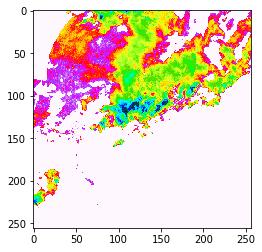

↓↓↓下面的是真实值，上面的是上一张↑↑↑


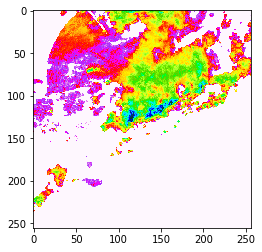

↓↓↓下面的是模型的输出，上面的是真实值↑↑↑


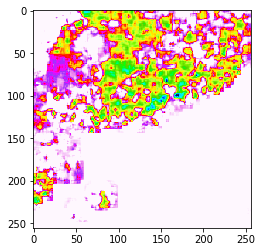

In [19]:
plt.imshow(x[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是真实值，上面的是上一张↑↑↑')
plt.imshow(y_[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的输出，上面的是真实值↑↑↑')
plt.imshow(y[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
plt.show()

In [ ]:
history.history

In [ ]:
RAD_id = RAD_id_list[3]
x_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
x_matrix = x_matrix.reshape((1, nt, image_size, image_size, 1))
y_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    y_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 10)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
y_matrix = y_matrix.reshape((1, nt, image_size, image_size, 1))

In [ ]:
plt.imshow(a.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (1, 1))
plt.imshow(b.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()

In [ ]:
input_shape = list(model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))

In [ ]:
print(x_matrix.shape)
print(y_matrix.shape)
print(a.shape)

In [ ]:
print(model.get_input_shape_at(0))
print(model.get_output_shape_at(0))

In [ ]:
%lsmagic

In [ ]:
%quickref

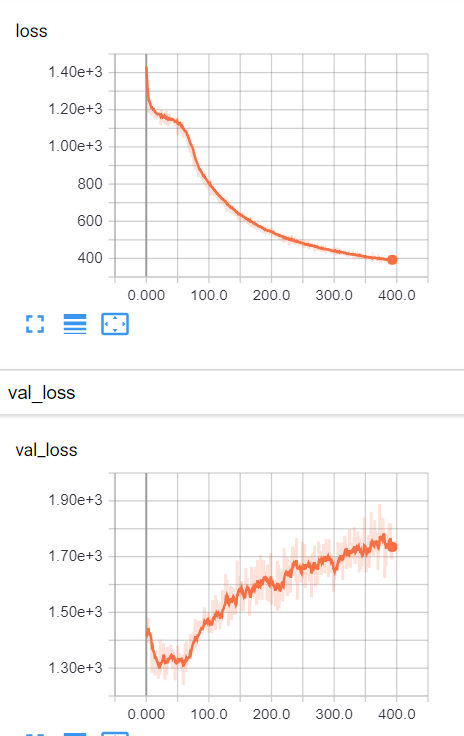
```
nt = 3
stack_sizes = (n_channels, 48, 96)  # (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (2, 2)
Ahat_filt_sizes = (2, 2, 2)
R_filt_sizes = (2, 2, 2)
mean_list.mean() < 3
```
`420/420`